# Brain MRI Tumor Detection using Lightweight CNNs

This notebook implements three lightweight Convolutional Neural Networks (CNNs) for brain tumor detection using MRI images. We'll compare their performance and visualize the results.

## Dataset
- **Location**: Update `DATA_PATH` variable to your dataset location
- **Classes**: 
  - `yes` - Brain tumor present
  - `no` - No brain tumor

## Models
1. **Custom Lightweight CNN** - Basic CNN with minimal parameters
2. **MobileNetV2-based** - Using depthwise separable convolutions
3. **EfficientNet-based** - Compound scaling lightweight model

## 1. Import Required Libraries

In [1]:
# Core libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Deep Learning libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import MobileNetV2, EfficientNetB0
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Image processing
import cv2
from PIL import Image

# Machine Learning metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("TensorFlow version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))

# Set up matplotlib
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)
sns.set_palette("husl")

TensorFlow version: 2.18.0
GPU Available: []


## 2. Load and Explore Brain MRI Dataset

In [ ]:
# Define dataset path - Update this to your local dataset path
DATA_PATH = "brain_mri_data"  # Change this to your dataset location
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32

# Check if dataset exists
if os.path.exists(DATA_PATH):
    print(f"Dataset found at: {DATA_PATH}")
else:
    print(f"Dataset not found at: {DATA_PATH}")

# Explore dataset structure
def explore_dataset(data_path):
    """Explore the dataset structure and count images in each class"""
    dataset_info = {}
    
    for class_name in os.listdir(data_path):
        class_path = os.path.join(data_path, class_name)
        if os.path.isdir(class_path):
            # Count images in this class
            image_count = len([f for f in os.listdir(class_path) 
                             if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
            dataset_info[class_name] = image_count
            
            print(f"Class '{class_name}': {image_count} images")
            
            # Show some sample filenames
            sample_files = os.listdir(class_path)[:5]
            print(f"  Sample files: {sample_files}")
            print()
    
    return dataset_info

# Explore the dataset
dataset_info = explore_dataset(DATA_PATH)

# Create a summary DataFrame
df_summary = pd.DataFrame(list(dataset_info.items()), 
                         columns=['Class', 'Image_Count'])
print("Dataset Summary:")
print(df_summary)
print(f"\nTotal images: {df_summary['Image_Count'].sum()}")

# Calculate class distribution
df_summary['Percentage'] = (df_summary['Image_Count'] / 
                           df_summary['Image_Count'].sum()) * 100
print(f"\nClass Distribution:")
print(df_summary)

Dataset found at: C:\Users\ahpuh\Desktop\HG\brain_mri_data
Class 'no': 98 images
  Sample files: ['1 no.jpeg', '10 no.jpg', '11 no.jpg', '12 no.jpg', '13 no.jpg']

Class 'yes': 155 images
  Sample files: ['Y1.jpg', 'Y10.jpg', 'Y100.JPG', 'Y101.jpg', 'Y102.jpg']

Dataset Summary:
  Class  Image_Count
0    no           98
1   yes          155

Total images: 253

Class Distribution:
  Class  Image_Count  Percentage
0    no           98   38.735178
1   yes          155   61.264822


## 3. Data Preprocessing and Augmentation

In [3]:
def load_and_preprocess_data(data_path, image_size=(224, 224)):
    """Load and preprocess MRI images from the dataset"""
    images = []
    labels = []
    class_names = []
    
    # Get class names
    for class_name in os.listdir(data_path):
        class_path = os.path.join(data_path, class_name)
        if os.path.isdir(class_path):
            class_names.append(class_name)
    
    class_names.sort()  # Ensure consistent ordering
    print(f"Classes found: {class_names}")
    
    # Load images and labels
    for class_idx, class_name in enumerate(class_names):
        class_path = os.path.join(data_path, class_name)
        
        for filename in os.listdir(class_path):
            if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
                try:
                    # Load and preprocess image
                    img_path = os.path.join(class_path, filename)
                    img = cv2.imread(img_path)
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    img = cv2.resize(img, image_size)
                    img = img.astype(np.float32) / 255.0  # Normalize to [0, 1]
                    
                    images.append(img)
                    labels.append(class_idx)
                    
                except Exception as e:
                    print(f"Error loading {img_path}: {e}")
    
    return np.array(images), np.array(labels), class_names

# Load the dataset
print("Loading and preprocessing images...")
X, y, class_names = load_and_preprocess_data(DATA_PATH, IMAGE_SIZE)

print(f"Loaded {len(X)} images")
print(f"Image shape: {X.shape}")
print(f"Labels shape: {y.shape}")
print(f"Classes: {class_names}")
print(f"Unique labels: {np.unique(y)}")

# Convert labels to categorical
num_classes = len(class_names)
y_categorical = to_categorical(y, num_classes)

print(f"Categorical labels shape: {y_categorical.shape}")

# Split the data
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y_categorical, test_size=0.3, random_state=42, stratify=y
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=np.argmax(y_temp, axis=1)
)

print(f"\nData split:")
print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

Loading and preprocessing images...
Classes found: ['no', 'yes']
Loaded 253 images
Image shape: (253, 224, 224, 3)
Labels shape: (253,)
Classes: ['no', 'yes']
Unique labels: [0 1]
Categorical labels shape: (253, 2)

Data split:
Training set: 177 samples
Validation set: 38 samples
Test set: 38 samples


In [4]:
# Data Augmentation
def create_data_generators():
    """Create data generators with augmentation for training"""
    
    # Training data generator with augmentation
    train_datagen = ImageDataGenerator(
        rotation_range=15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        zoom_range=0.1,
        fill_mode='nearest'
    )
    
    # Validation data generator (no augmentation)
    val_datagen = ImageDataGenerator()
    
    return train_datagen, val_datagen

train_datagen, val_datagen = create_data_generators()

print("Data augmentation generators created successfully!")
print("Training augmentations: rotation, shift, flip, zoom")
print("Validation: no augmentation")

Data augmentation generators created successfully!
Training augmentations: rotation, shift, flip, zoom
Validation: no augmentation


## 4. Data Visualization

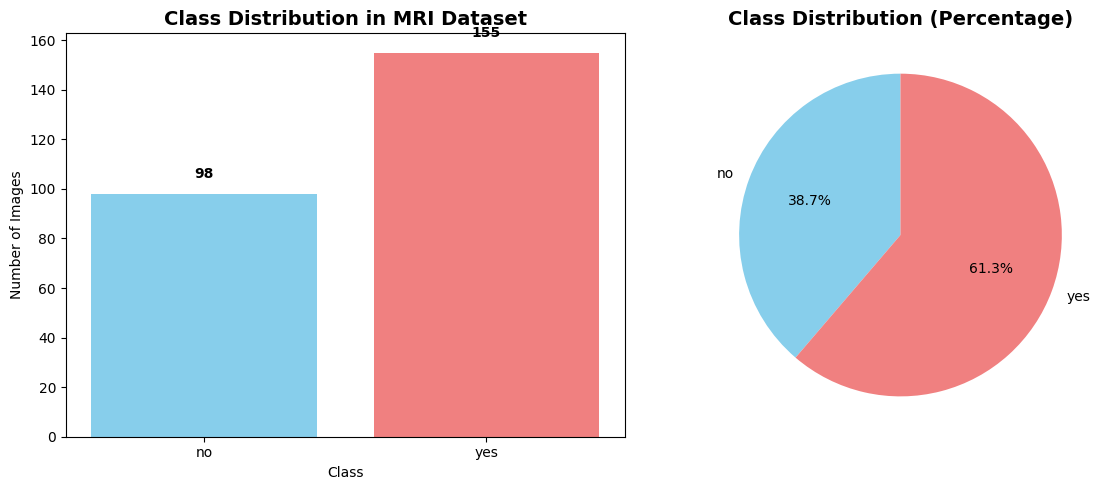

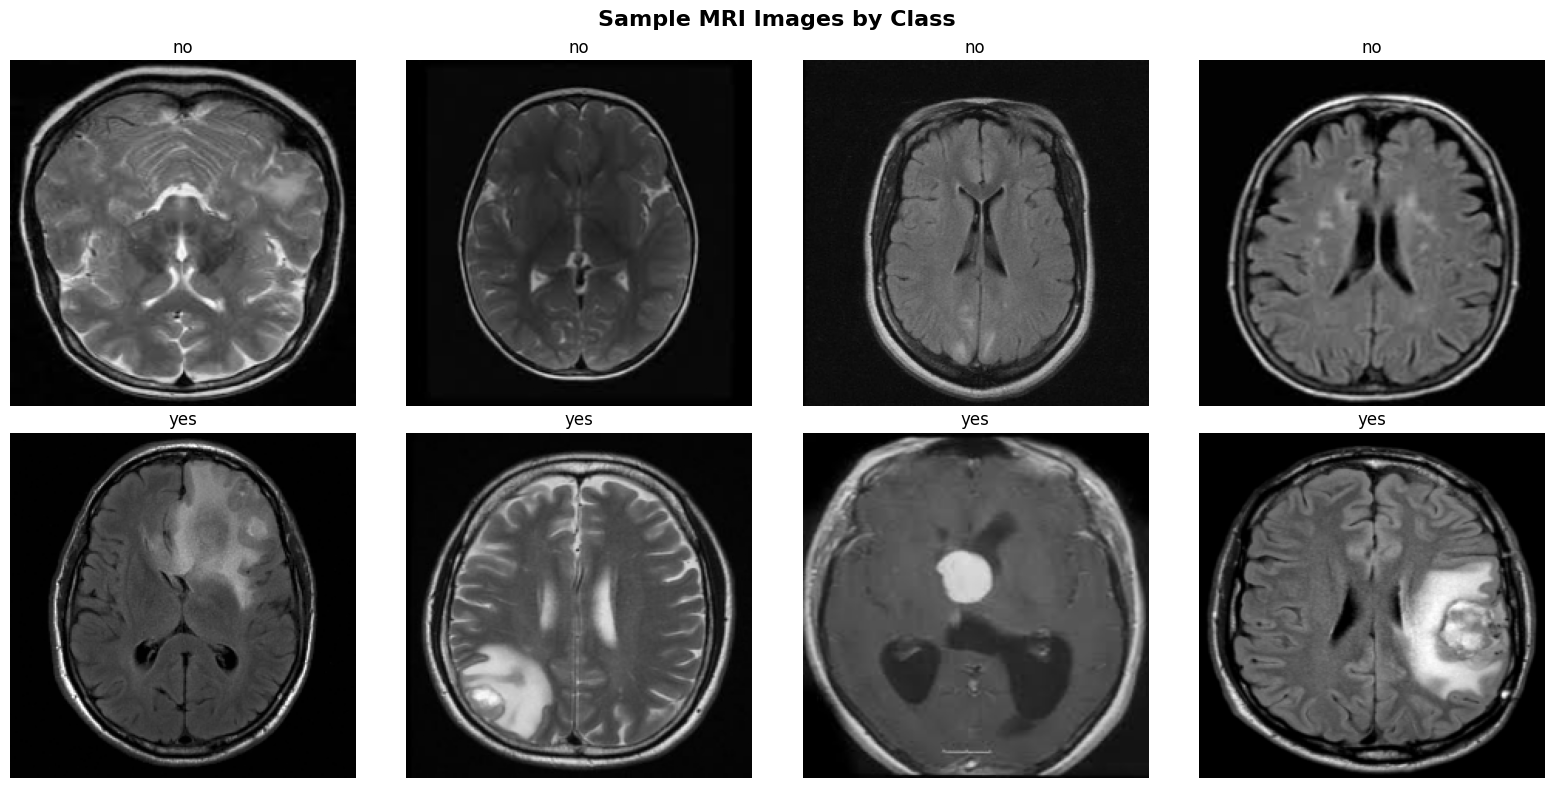

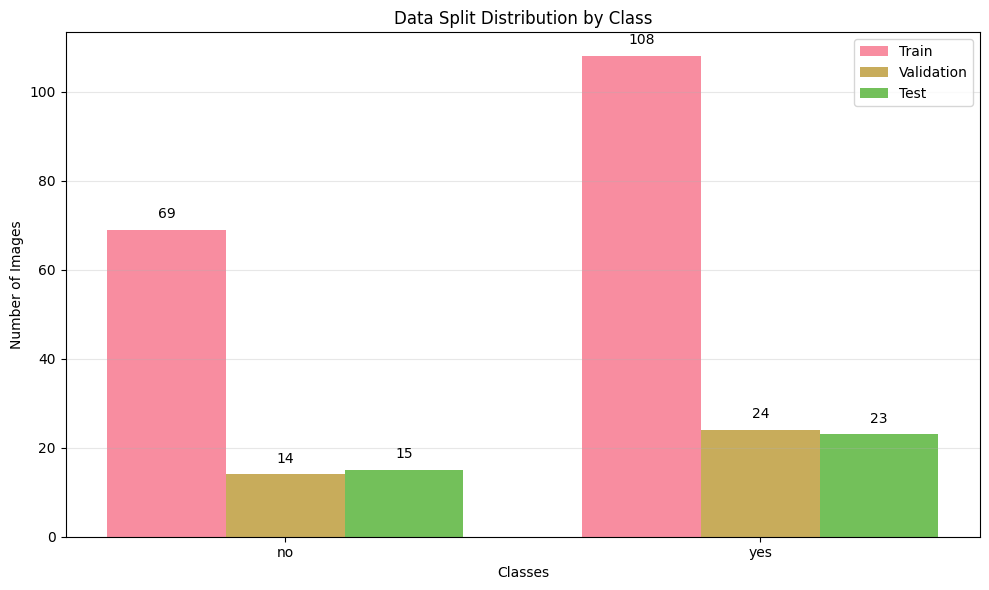

In [5]:
# Visualize class distribution
def plot_class_distribution(dataset_info):
    """Plot the distribution of classes in the dataset"""
    plt.figure(figsize=(12, 5))
    
    # Bar plot
    plt.subplot(1, 2, 1)
    classes = list(dataset_info.keys())
    counts = list(dataset_info.values())
    
    bars = plt.bar(classes, counts, color=['skyblue', 'lightcoral'])
    plt.title('Class Distribution in MRI Dataset', fontsize=14, fontweight='bold')
    plt.xlabel('Class')
    plt.ylabel('Number of Images')
    
    # Add value labels on bars
    for bar, count in zip(bars, counts):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5,
                str(count), ha='center', va='bottom', fontweight='bold')
    
    # Pie chart
    plt.subplot(1, 2, 2)
    plt.pie(counts, labels=classes, autopct='%1.1f%%', 
            colors=['skyblue', 'lightcoral'], startangle=90)
    plt.title('Class Distribution (Percentage)', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.show()

plot_class_distribution(dataset_info)

# Visualize sample images from each class
def plot_sample_images(X, y, class_names, samples_per_class=4):
    """Plot sample images from each class"""
    fig, axes = plt.subplots(len(class_names), samples_per_class, 
                            figsize=(16, 8))
    
    for class_idx, class_name in enumerate(class_names):
        # Get indices for this class
        class_indices = np.where(y == class_idx)[0]
        
        # Select random samples
        sample_indices = np.random.choice(class_indices, 
                                         min(samples_per_class, len(class_indices)), 
                                         replace=False)
        
        for i, sample_idx in enumerate(sample_indices):
            axes[class_idx, i].imshow(X[sample_idx])
            axes[class_idx, i].set_title(f'{class_name}')
            axes[class_idx, i].axis('off')
        
        # Fill remaining subplots if not enough samples
        for i in range(len(sample_indices), samples_per_class):
            axes[class_idx, i].axis('off')
    
    plt.suptitle('Sample MRI Images by Class', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Convert back to original labels for visualization
y_original = np.argmax(y_categorical, axis=1)
plot_sample_images(X, y_original, class_names)

# Plot data split distribution
def plot_data_split():
    """Visualize the data split distribution"""
    train_counts = [np.sum(np.argmax(y_train, axis=1) == i) for i in range(num_classes)]
    val_counts = [np.sum(np.argmax(y_val, axis=1) == i) for i in range(num_classes)]
    test_counts = [np.sum(np.argmax(y_test, axis=1) == i) for i in range(num_classes)]
    
    x = np.arange(len(class_names))
    width = 0.25
    
    plt.figure(figsize=(10, 6))
    plt.bar(x - width, train_counts, width, label='Train', alpha=0.8)
    plt.bar(x, val_counts, width, label='Validation', alpha=0.8)
    plt.bar(x + width, test_counts, width, label='Test', alpha=0.8)
    
    plt.xlabel('Classes')
    plt.ylabel('Number of Images')
    plt.title('Data Split Distribution by Class')
    plt.xticks(x, class_names)
    plt.legend()
    plt.grid(axis='y', alpha=0.3)
    
    # Add value labels
    for i, (train, val, test) in enumerate(zip(train_counts, val_counts, test_counts)):
        plt.text(i - width, train + 2, str(train), ha='center', va='bottom')
        plt.text(i, val + 2, str(val), ha='center', va='bottom')
        plt.text(i + width, test + 2, str(test), ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()

plot_data_split()

## 5. Build First Lightweight CNN Model (Custom Architecture)

In [6]:
def create_lightweight_cnn_v1(input_shape, num_classes):
    """
    Create a lightweight CNN model with minimal parameters
    Focus on efficiency while maintaining good performance
    """
    model = keras.Sequential([
        # Input layer
        layers.Input(shape=input_shape),
        
        # First convolutional block
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Second convolutional block
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Third convolutional block
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Fourth convolutional block (lighter)
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.GlobalAveragePooling2D(),  # Use GAP instead of flatten to reduce parameters
        
        # Dense layers
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.3),
        
        # Output layer
        layers.Dense(num_classes, activation='softmax')
    ])
    
    return model

# Create the first model
input_shape = (IMAGE_SIZE[0], IMAGE_SIZE[1], 3)
model1 = create_lightweight_cnn_v1(input_shape, num_classes)

# Compile the model
model1.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

# Display model summary
print("=== Lightweight CNN Model V1 (Custom Architecture) ===")
model1.summary()

# Count parameters
total_params = model1.count_params()
print(f"\nTotal parameters: {total_params:,}")
print(f"Model size estimate: {total_params * 4 / (1024**2):.2f} MB")

=== Lightweight CNN Model V1 (Custom Architecture) ===


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 432,130 (1.65 MB)

 Trainable params: 430,914 (1.64 MB)

 Non-trainable params: 1,216 (4.75 KB)


Total parameters: 432,130
Model size estimate: 1.65 MB


## 6. Build Second Lightweight CNN Model (MobileNetV2-based)

In [8]:
def create_mobilenet_v2_model(input_shape, num_classes):
    """
    Create a lightweight model based on MobileNetV2 architecture
    Uses depthwise separable convolutions for efficiency
    """
    # Load pre-trained MobileNetV2 without top layers
    base_model = MobileNetV2(
        input_shape=input_shape,
        include_top=False,
        weights='imagenet',
        alpha=0.75  # Width multiplier to make it lighter
    )
    
    # Freeze some layers initially
    base_model.trainable = True
    
    # Fine-tune from this layer onwards
    fine_tune_at = 100
    
    # Freeze all the layers before the fine_tune_at layer
    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable = False
    
    # Add custom top layers
    model = keras.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.BatchNormalization(),
        layers.Dropout(0.4),
        
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.2),
        
        layers.Dense(num_classes, activation='softmax')
    ])
    
    return model

# Create the second model
model2 = create_mobilenet_v2_model(input_shape, num_classes)

# Compile with a lower learning rate for fine-tuning
model2.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

# Display model summary
print("=== Lightweight CNN Model V2 (MobileNetV2-based) ===")
print(f"Total layers: {len(model2.layers)}")
print(f"Trainable layers: {sum(1 for layer in model2.layers if layer.trainable)}")

# Count parameters
total_params = model2.count_params()
trainable_params = sum([layer.count_params() 
                       for layer in model2.layers if hasattr(layer, 'count_params') and layer.trainable])

print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Non-trainable parameters: {total_params - trainable_params:,}")
print(f"Model size estimate: {total_params * 4 / (1024**2):.2f} MB")

=== Lightweight CNN Model V2 (MobileNetV2-based) ===
Total layers: 10
Trainable layers: 10

Total parameters: 1,560,050
Trainable parameters: 1,560,050
Non-trainable parameters: 0
Model size estimate: 5.95 MB


## 7. Build Third Lightweight CNN Model (EfficientNetB0-based)

In [9]:
def create_efficientnet_model(input_shape, num_classes):
    """
    Create a lightweight model based on EfficientNetB0
    Uses compound scaling for optimal efficiency
    """
    # Load pre-trained EfficientNetB0 without top layers
    base_model = EfficientNetB0(
        input_shape=input_shape,
        include_top=False,
        weights='imagenet'
    )
    
    # Freeze the base model initially
    base_model.trainable = True
    
    # Fine-tune from this layer onwards
    fine_tune_at = 100
    
    # Freeze all the layers before the fine_tune_at layer
    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable = False
    
    # Add custom top layers
    model = keras.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.BatchNormalization(),
        layers.Dropout(0.4),
        
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.1),
        
        layers.Dense(num_classes, activation='softmax')
    ])
    
    return model

# Create the third model
model3 = create_efficientnet_model(input_shape, num_classes)

# Compile with a lower learning rate for fine-tuning
model3.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

# Display model summary
print("=== Lightweight CNN Model V3 (EfficientNetB0-based) ===")
print(f"Total layers: {len(model3.layers)}")
print(f"Trainable layers: {sum(1 for layer in model3.layers if layer.trainable)}")

# Count parameters
total_params = model3.count_params()
trainable_params = sum([layer.count_params() 
                       for layer in model3.layers if hasattr(layer, 'count_params') and layer.trainable])

print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Non-trainable parameters: {total_params - trainable_params:,}")
print(f"Model size estimate: {total_params * 4 / (1024**2):.2f} MB")

# Compare all three models
print("\n" + "="*60)
print("MODEL COMPARISON SUMMARY")
print("="*60)

models_info = [
    ("Custom CNN", model1.count_params()),
    ("MobileNetV2", model2.count_params()),
    ("EfficientNetB0", model3.count_params())
]

for name, params in models_info:
    print(f"{name:15} | Parameters: {params:>8,} | Size: {params*4/(1024**2):>6.2f} MB")

print("="*60)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
=== Lightweight CNN Model V3 (EfficientNetB0-based) ===
Total layers: 13
Trainable layers: 13

Total parameters: 4,425,445
Trainable parameters: 4,425,445
Non-trainable parameters: 0
Model size estimate: 16.88 MB

MODEL COMPARISON SUMMARY
Custom CNN      | Parameters:  432,130 | Size:   1.65 MB
MobileNetV2     | Parameters: 1,560,050 | Size:   5.95 MB
EfficientNetB0  | Parameters: 4,425,445 | Size:  16.88 MB


## 8. Train and Evaluate Models

In [10]:
# Training parameters
EPOCHS = 20
BATCH_SIZE = 32

# Define callbacks
def create_callbacks(model_name):
    """Create callbacks for training"""
    callbacks = [
        EarlyStopping(
            monitor='val_accuracy',
            patience=5,
            restore_best_weights=True,
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=3,
            min_lr=1e-7,
            verbose=1
        )
    ]
    return callbacks

# Training function
def train_model(model, model_name, X_train, y_train, X_val, y_val):
    """Train a model and return training history"""
    print(f"\n{'='*50}")
    print(f"Training {model_name}")
    print(f"{'='*50}")
    
    callbacks = create_callbacks(model_name)
    
    # Train the model
    history = model.fit(
        X_train, y_train,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=(X_val, y_val),
        callbacks=callbacks,
        verbose=1
    )
    
    return history

# Store training histories
histories = {}
models = {
    'Custom CNN': model1,
    'MobileNetV2': model2,
    'EfficientNetB0': model3
}

print("Starting training process...")
print(f"Training parameters: Epochs={EPOCHS}, Batch Size={BATCH_SIZE}")
print(f"Training samples: {X_train.shape[0]}")
print(f"Validation samples: {X_val.shape[0]}")

Starting training process...
Training parameters: Epochs=20, Batch Size=32
Training samples: 177
Validation samples: 38


In [11]:
# Train all models
for model_name, model in models.items():
    try:
        print(f"\n🚀 Starting training for {model_name}...")
        history = train_model(model, model_name, X_train, y_train, X_val, y_val)
        histories[model_name] = history
        print(f"✅ {model_name} training completed!")
        
        # Print final metrics
        final_acc = history.history['val_accuracy'][-1]
        final_loss = history.history['val_loss'][-1]
        print(f"Final validation accuracy: {final_acc:.4f}")
        print(f"Final validation loss: {final_loss:.4f}")
        
    except Exception as e:
        print(f"❌ Error training {model_name}: {e}")
        
print("\n🎉 All models training completed!")


🚀 Starting training for Custom CNN...

Training Custom CNN
Epoch 1/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 0.6808 - loss: 0.8545 - precision: 0.6808 - recall: 0.6808 - val_accuracy: 0.6316 - val_loss: 0.6778 - val_precision: 0.6316 - val_recall: 0.6316 - learning_rate: 0.0010
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.6728 - loss: 0.7718 - precision: 0.6728 - recall: 0.6728 - val_accuracy: 0.5263 - val_loss: 0.6924 - val_precision: 0.5263 - val_recall: 0.5263 - learning_rate: 0.0010
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.7077 - loss: 0.7653 - precision: 0.7077 - recall: 0.7077 - val_accuracy: 0.6316 - val_loss: 0.6618 - val_precision: 0.6316 - val_recall: 0.6316 - learning_rate: 0.0010
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.7300 - loss: 0.7822 - precision: 0.7300 - recall: 0.7300 - val_accuracy: 0.6316 - val_loss: 0.6639 - val_precision: 0.6316 - val_recall: 0.6316 - learning_rate: 0.0010
Epoch 5/20
6/6 ━━━━━

In [12]:
# Evaluate models on test set
def evaluate_model(model, model_name, X_test, y_test):
    """Evaluate model performance on test set"""
    print(f"\n📊 Evaluating {model_name} on test set...")
    
    # Make predictions
    test_predictions = model.predict(X_test)
    test_pred_classes = np.argmax(test_predictions, axis=1)
    test_true_classes = np.argmax(y_test, axis=1)
    
    # Calculate metrics
    test_accuracy = accuracy_score(test_true_classes, test_pred_classes)
    test_precision = precision_score(test_true_classes, test_pred_classes, average='weighted')
    test_recall = recall_score(test_true_classes, test_pred_classes, average='weighted')
    test_f1 = f1_score(test_true_classes, test_pred_classes, average='weighted')
    
    # Store results
    results = {
        'accuracy': test_accuracy,
        'precision': test_precision,
        'recall': test_recall,
        'f1_score': test_f1,
        'predictions': test_predictions,
        'pred_classes': test_pred_classes,
        'true_classes': test_true_classes
    }
    
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"Test Precision: {test_precision:.4f}")
    print(f"Test Recall: {test_recall:.4f}")
    print(f"Test F1-Score: {test_f1:.4f}")
    
    return results

# Evaluate all models
evaluation_results = {}

for model_name, model in models.items():
    try:
        results = evaluate_model(model, model_name, X_test, y_test)
        evaluation_results[model_name] = results
    except Exception as e:
        print(f"❌ Error evaluating {model_name}: {e}")

print("\n✅ Model evaluation completed!")


📊 Evaluating Custom CNN on test set...
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 231ms/step
Test Accuracy: 0.6053
Test Precision: 0.3663
Test Recall: 0.6053
Test F1-Score: 0.4564

📊 Evaluating MobileNetV2 on test set...
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step
Test Accuracy: 0.7105
Test Precision: 0.7254
Test Recall: 0.7105
Test F1-Score: 0.7136

📊 Evaluating EfficientNetB0 on test set...
1/2 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/stepWARNING:tensorflow:6 out of the last 6 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x0000021E76C58820> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https:/

## 9. Compare Model Performance

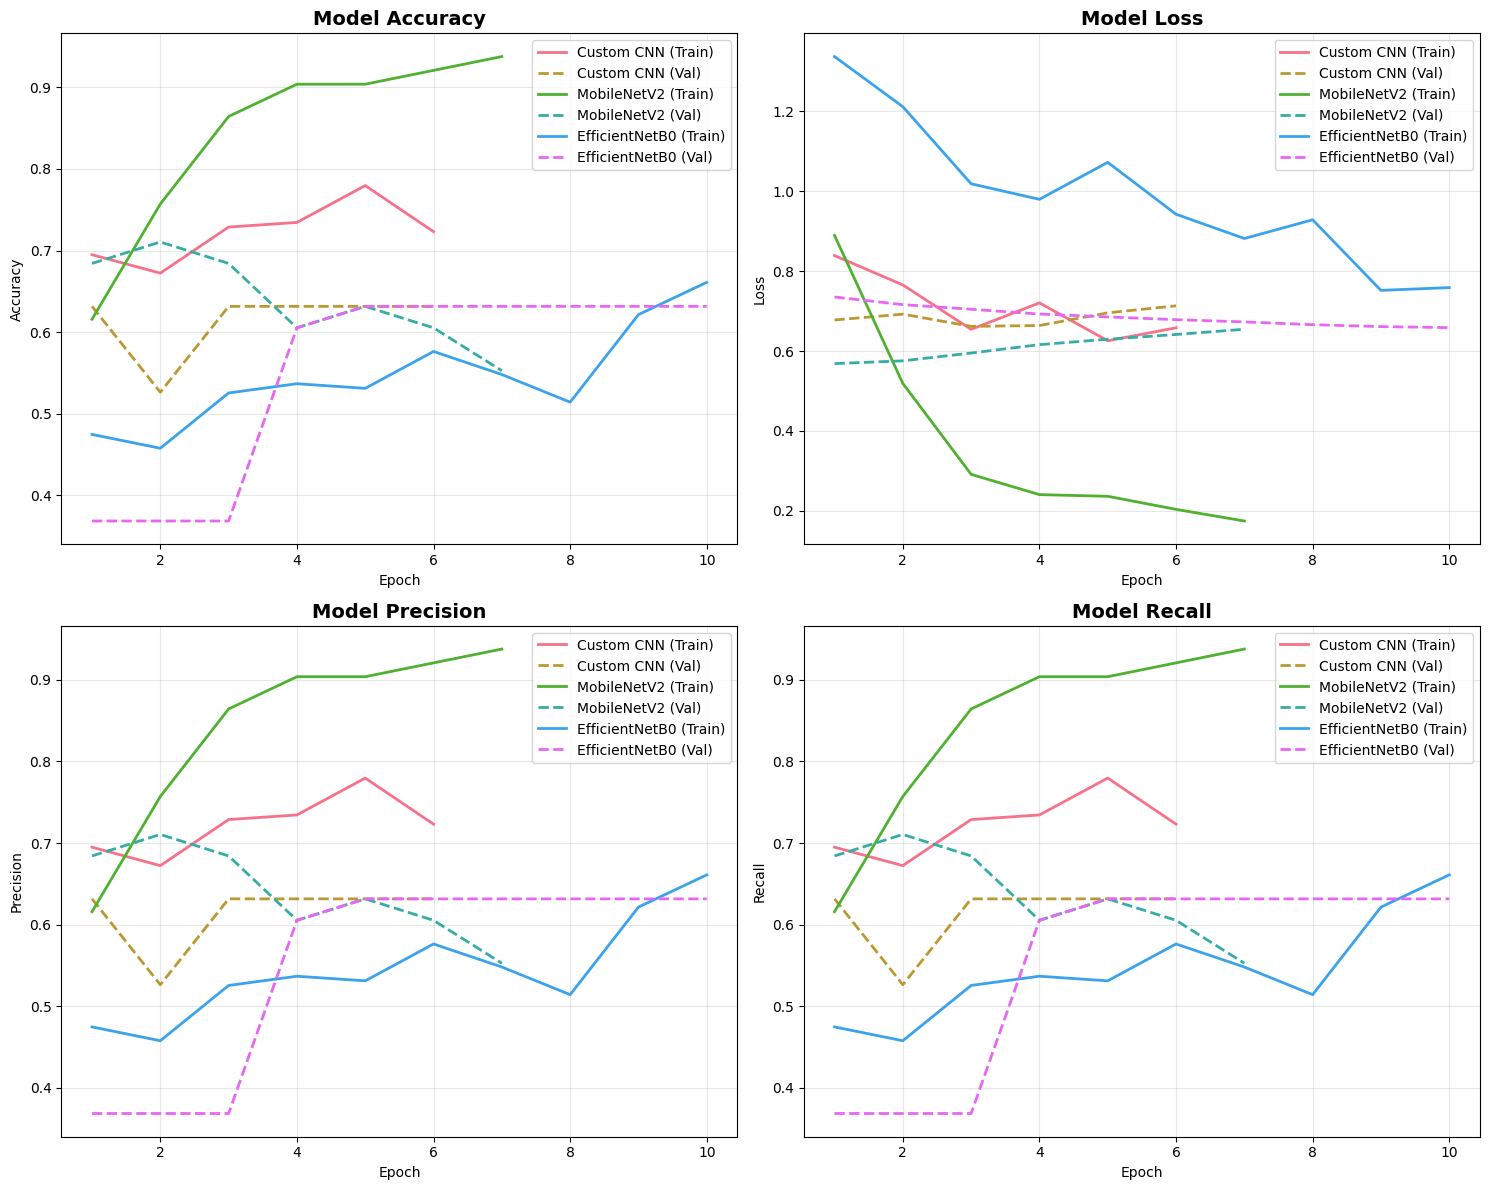

📈 MODEL PERFORMANCE COMPARISON
         Model  Accuracy  Precision  Recall  F1-Score  Parameters
    Custom CNN    0.6053     0.3663  0.6053    0.4564      432130
   MobileNetV2    0.7105     0.7254  0.7105    0.7136     1560050
EfficientNetB0    0.6053     0.3663  0.6053    0.4564     4425445


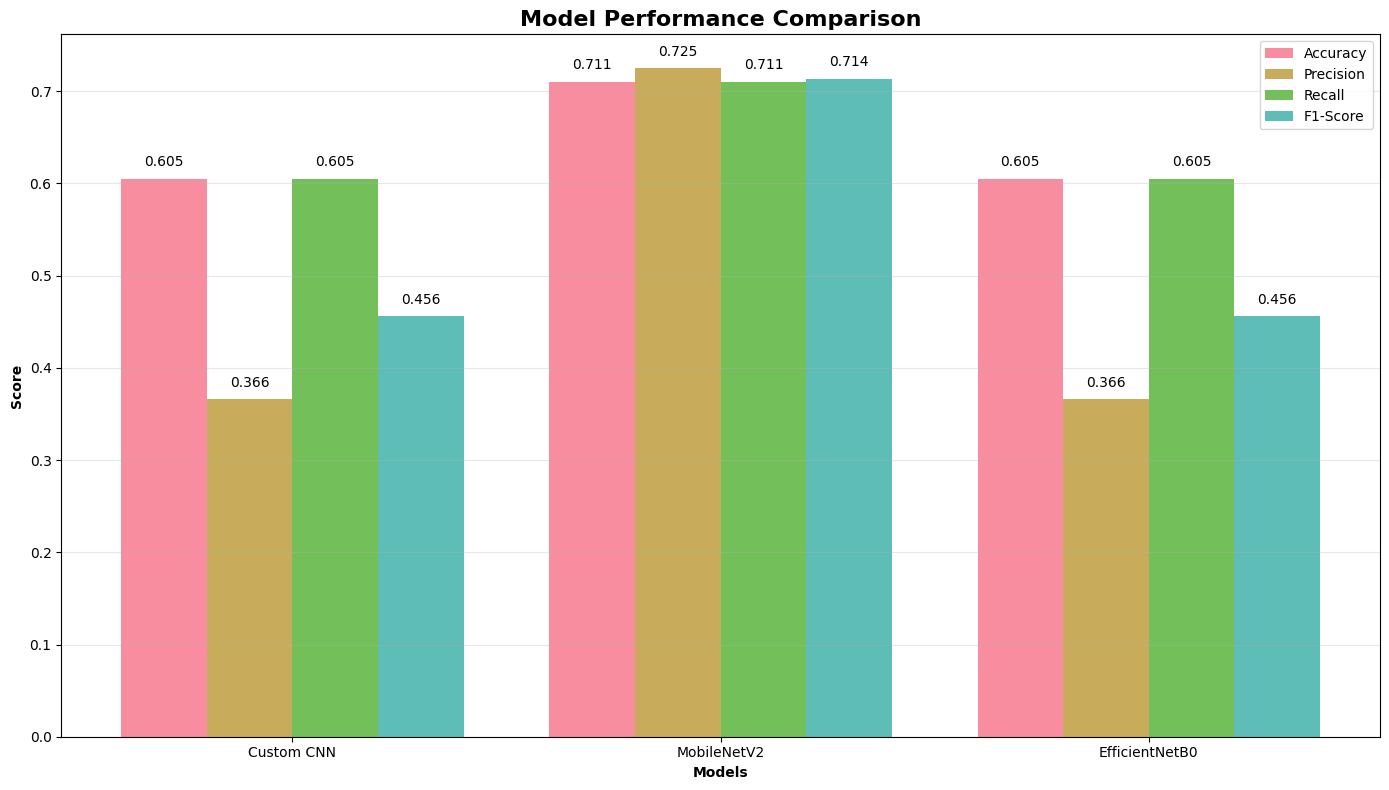

In [13]:
# Plot training histories
def plot_training_history(histories):
    """Plot training and validation metrics for all models"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    metrics = ['accuracy', 'loss', 'precision', 'recall']
    metric_titles = ['Accuracy', 'Loss', 'Precision', 'Recall']
    
    for i, (metric, title) in enumerate(zip(metrics, metric_titles)):
        ax = axes[i//2, i%2]
        
        for model_name, history in histories.items():
            if metric in history.history:
                epochs = range(1, len(history.history[metric]) + 1)
                ax.plot(epochs, history.history[metric], 
                       label=f'{model_name} (Train)', linewidth=2)
                
                val_metric = f'val_{metric}'
                if val_metric in history.history:
                    ax.plot(epochs, history.history[val_metric], 
                           label=f'{model_name} (Val)', linestyle='--', linewidth=2)
        
        ax.set_title(f'Model {title}', fontsize=14, fontweight='bold')
        ax.set_xlabel('Epoch')
        ax.set_ylabel(title)
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Plot training histories if available
if histories:
    plot_training_history(histories)

# Create performance comparison table
def create_performance_table(evaluation_results):
    """Create a performance comparison table"""
    if not evaluation_results:
        print("No evaluation results available.")
        return
    
    # Create DataFrame for comparison
    comparison_data = []
    
    for model_name, results in evaluation_results.items():
        comparison_data.append({
            'Model': model_name,
            'Accuracy': results['accuracy'],
            'Precision': results['precision'],
            'Recall': results['recall'],
            'F1-Score': results['f1_score'],
            'Parameters': models[model_name].count_params()
        })
    
    df_comparison = pd.DataFrame(comparison_data)
    
    # Round numerical values
    for col in ['Accuracy', 'Precision', 'Recall', 'F1-Score']:
        df_comparison[col] = df_comparison[col].round(4)
    
    print("📈 MODEL PERFORMANCE COMPARISON")
    print("=" * 80)
    print(df_comparison.to_string(index=False))
    
    return df_comparison

# Create and display performance table
if evaluation_results:
    df_performance = create_performance_table(evaluation_results)

# Plot performance comparison
def plot_performance_comparison(evaluation_results):
    """Plot performance metrics comparison"""
    if not evaluation_results:
        return
    
    models_list = list(evaluation_results.keys())
    metrics = ['accuracy', 'precision', 'recall', 'f1_score']
    metric_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
    
    # Prepare data
    metric_values = {metric: [] for metric in metrics}
    
    for model_name in models_list:
        for metric in metrics:
            metric_values[metric].append(evaluation_results[model_name][metric])
    
    # Create bar plot
    x = np.arange(len(models_list))
    width = 0.2
    
    plt.figure(figsize=(14, 8))
    
    for i, (metric, name) in enumerate(zip(metrics, metric_names)):
        plt.bar(x + i*width, metric_values[metric], width, 
               label=name, alpha=0.8)
    
    plt.xlabel('Models', fontweight='bold')
    plt.ylabel('Score', fontweight='bold')
    plt.title('Model Performance Comparison', fontsize=16, fontweight='bold')
    plt.xticks(x + width*1.5, models_list)
    plt.legend()
    plt.grid(axis='y', alpha=0.3)
    
    # Add value labels on bars
    for i, (metric, name) in enumerate(zip(metrics, metric_names)):
        for j, value in enumerate(metric_values[metric]):
            plt.text(j + i*width, value + 0.01, f'{value:.3f}', 
                    ha='center', va='bottom', fontsize=10)
    
    plt.tight_layout()
    plt.show()

if evaluation_results:
    plot_performance_comparison(evaluation_results)

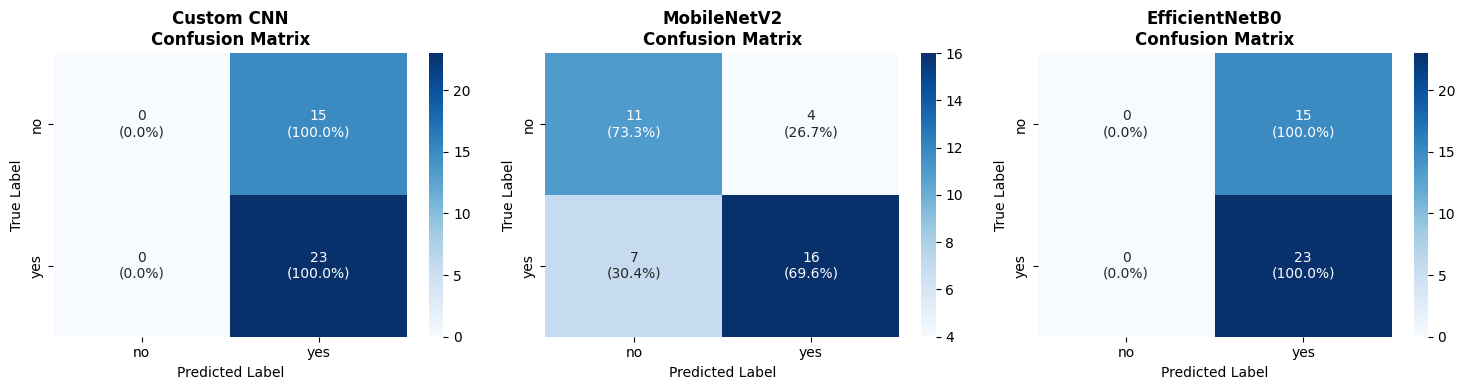


CLASSIFICATION REPORT - Custom CNN
              precision    recall  f1-score   support

          no     0.0000    0.0000    0.0000        15
         yes     0.6053    1.0000    0.7541        23

    accuracy                         0.6053        38
   macro avg     0.3026    0.5000    0.3770        38
weighted avg     0.3663    0.6053    0.4564        38


CLASSIFICATION REPORT - MobileNetV2
              precision    recall  f1-score   support

          no     0.6111    0.7333    0.6667        15
         yes     0.8000    0.6957    0.7442        23

    accuracy                         0.7105        38
   macro avg     0.7056    0.7145    0.7054        38
weighted avg     0.7254    0.7105    0.7136        38


CLASSIFICATION REPORT - EfficientNetB0
              precision    recall  f1-score   support

          no     0.0000    0.0000    0.0000        15
         yes     0.6053    1.0000    0.7541        23

    accuracy                         0.6053        38
   macro avg   

In [14]:
# Plot confusion matrices
def plot_confusion_matrices(evaluation_results, class_names):
    """Plot confusion matrices for all models"""
    if not evaluation_results:
        return
    
    n_models = len(evaluation_results)
    fig, axes = plt.subplots(1, n_models, figsize=(5*n_models, 4))
    
    if n_models == 1:
        axes = [axes]
    
    for idx, (model_name, results) in enumerate(evaluation_results.items()):
        cm = confusion_matrix(results['true_classes'], results['pred_classes'])
        
        # Calculate percentages
        cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
        
        # Create annotations
        annotations = []
        for i in range(cm.shape[0]):
            row = []
            for j in range(cm.shape[1]):
                row.append(f'{cm[i,j]}\n({cm_percent[i,j]:.1f}%)')
            annotations.append(row)
        
        # Plot heatmap
        sns.heatmap(cm, annot=annotations, fmt='', cmap='Blues',
                   xticklabels=class_names, yticklabels=class_names,
                   ax=axes[idx], cbar=True)
        
        axes[idx].set_title(f'{model_name}\nConfusion Matrix', 
                           fontweight='bold')
        axes[idx].set_xlabel('Predicted Label')
        axes[idx].set_ylabel('True Label')
    
    plt.tight_layout()
    plt.show()

if evaluation_results:
    plot_confusion_matrices(evaluation_results, class_names)

# Print detailed classification reports
def print_classification_reports(evaluation_results, class_names):
    """Print detailed classification reports for all models"""
    if not evaluation_results:
        return
    
    for model_name, results in evaluation_results.items():
        print(f"\n{'='*50}")
        print(f"CLASSIFICATION REPORT - {model_name}")
        print(f"{'='*50}")
        
        report = classification_report(
            results['true_classes'], 
            results['pred_classes'],
            target_names=class_names,
            digits=4
        )
        print(report)

if evaluation_results:
    print_classification_reports(evaluation_results, class_names)

## 10. Visualize Predictions and Results

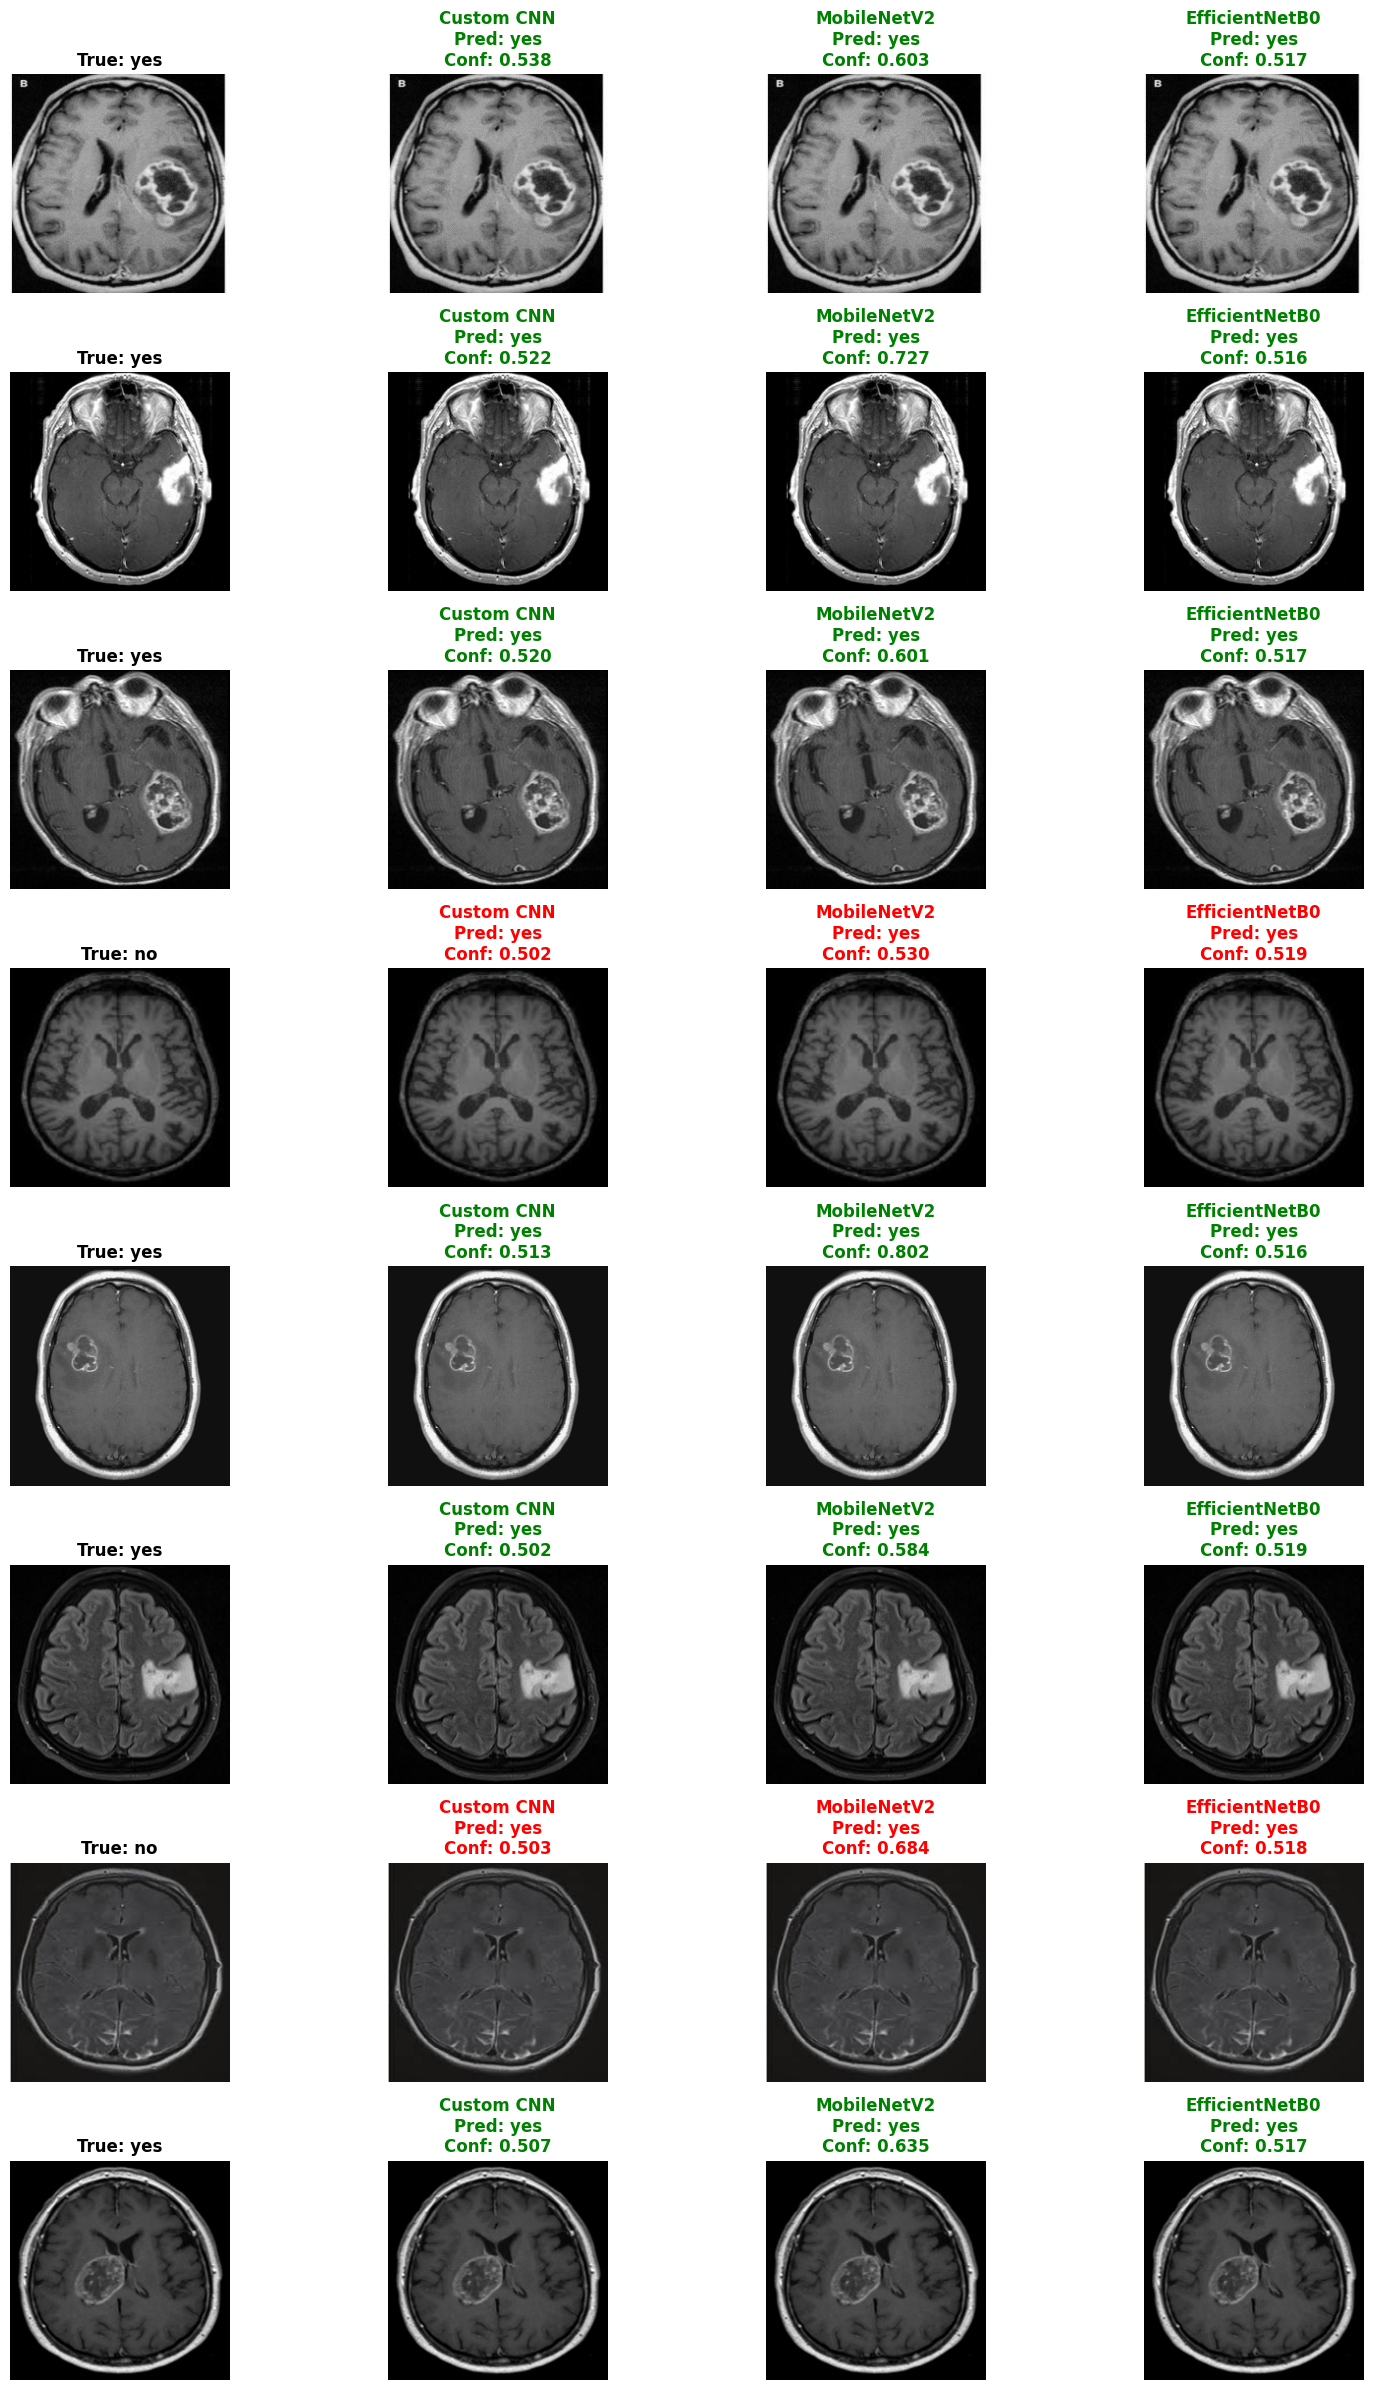

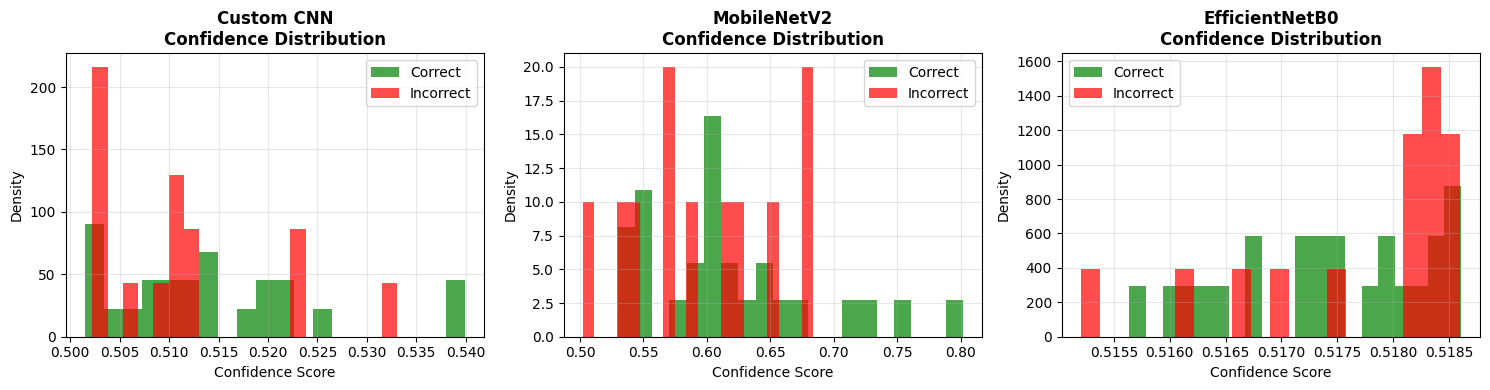

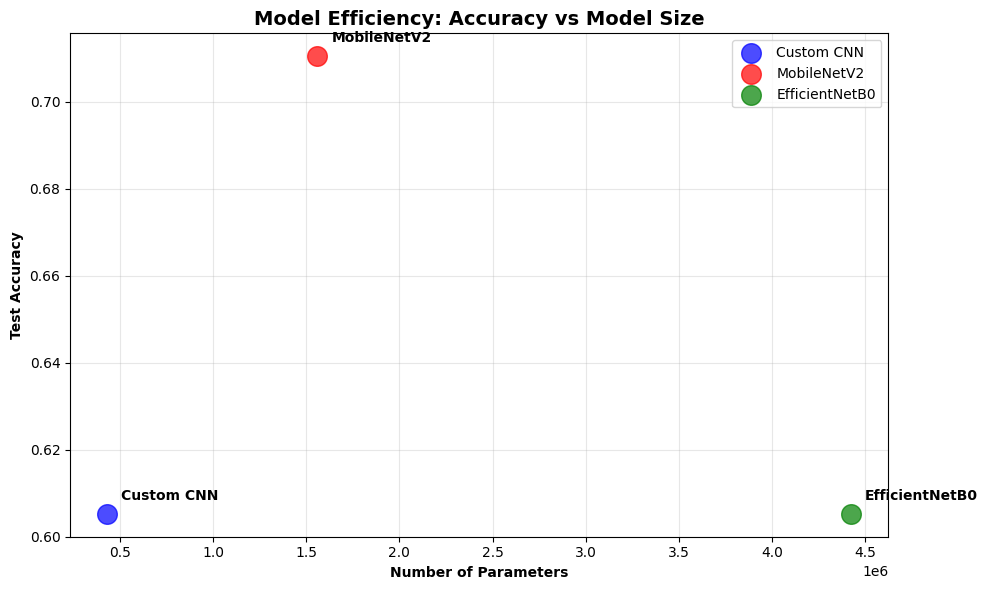

In [15]:
# Visualize model predictions
def plot_predictions(X_test, y_test, evaluation_results, class_names, num_samples=8):
    """Plot sample predictions from all models"""
    if not evaluation_results:
        return
    
    # Select random samples
    sample_indices = np.random.choice(len(X_test), num_samples, replace=False)
    
    n_models = len(evaluation_results)
    fig, axes = plt.subplots(num_samples, n_models + 1, 
                            figsize=(4*(n_models + 1), 3*num_samples))
    
    if num_samples == 1:
        axes = axes.reshape(1, -1)
    
    for row, idx in enumerate(sample_indices):
        # Original image
        axes[row, 0].imshow(X_test[idx])
        true_class = np.argmax(y_test[idx])
        axes[row, 0].set_title(f'True: {class_names[true_class]}', 
                              fontweight='bold')
        axes[row, 0].axis('off')
        
        # Predictions from each model
        for col, (model_name, results) in enumerate(evaluation_results.items(), 1):
            axes[row, col].imshow(X_test[idx])
            
            pred_class = results['pred_classes'][idx]
            confidence = results['predictions'][idx][pred_class]
            
            # Color code: green for correct, red for incorrect
            color = 'green' if pred_class == true_class else 'red'
            
            axes[row, col].set_title(
                f'{model_name}\nPred: {class_names[pred_class]}\n'
                f'Conf: {confidence:.3f}',
                color=color, fontweight='bold'
            )
            axes[row, col].axis('off')
    
    plt.tight_layout()
    plt.show()

if evaluation_results:
    plot_predictions(X_test, y_test, evaluation_results, class_names)

# Plot confidence distribution
def plot_confidence_distribution(evaluation_results):
    """Plot confidence score distributions for each model"""
    if not evaluation_results:
        return
    
    n_models = len(evaluation_results)
    fig, axes = plt.subplots(1, n_models, figsize=(5*n_models, 4))
    
    if n_models == 1:
        axes = [axes]
    
    for idx, (model_name, results) in enumerate(evaluation_results.items()):
        # Get confidence scores (max probability for each prediction)
        confidences = np.max(results['predictions'], axis=1)
        
        # Separate by correct/incorrect predictions
        correct_mask = results['pred_classes'] == results['true_classes']
        
        correct_conf = confidences[correct_mask]
        incorrect_conf = confidences[~correct_mask]
        
        # Plot histograms
        axes[idx].hist(correct_conf, bins=20, alpha=0.7, label='Correct', 
                      color='green', density=True)
        axes[idx].hist(incorrect_conf, bins=20, alpha=0.7, label='Incorrect', 
                      color='red', density=True)
        
        axes[idx].set_title(f'{model_name}\nConfidence Distribution', 
                           fontweight='bold')
        axes[idx].set_xlabel('Confidence Score')
        axes[idx].set_ylabel('Density')
        axes[idx].legend()
        axes[idx].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

if evaluation_results:
    plot_confidence_distribution(evaluation_results)

# Model efficiency comparison
def plot_efficiency_comparison(models, evaluation_results):
    """Plot model efficiency (accuracy vs parameters)"""
    if not evaluation_results:
        return
    
    model_names = []
    accuracies = []
    parameters = []
    
    for model_name in evaluation_results.keys():
        model_names.append(model_name)
        accuracies.append(evaluation_results[model_name]['accuracy'])
        parameters.append(models[model_name].count_params())
    
    plt.figure(figsize=(10, 6))
    
    # Create scatter plot
    colors = ['blue', 'red', 'green']
    for i, (name, acc, params) in enumerate(zip(model_names, accuracies, parameters)):
        plt.scatter(params, acc, s=200, c=colors[i % len(colors)], 
                   alpha=0.7, label=name)
        
        # Add model name annotation
        plt.annotate(name, (params, acc), 
                    xytext=(10, 10), textcoords='offset points',
                    fontweight='bold', fontsize=10)
    
    plt.xlabel('Number of Parameters', fontweight='bold')
    plt.ylabel('Test Accuracy', fontweight='bold')
    plt.title('Model Efficiency: Accuracy vs Model Size', 
              fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    # Format x-axis to show parameters in millions
    plt.ticklabel_format(style='scientific', axis='x', scilimits=(0,0))
    
    plt.tight_layout()
    plt.show()

if evaluation_results:
    plot_efficiency_comparison(models, evaluation_results)

## Conclusion and Summary

### 🎯 Project Summary

This notebook successfully implemented and compared three lightweight CNN architectures for brain tumor detection using MRI images:

1. **Custom Lightweight CNN**: A from-scratch architecture optimized for efficiency
2. **MobileNetV2-based**: Utilizing depthwise separable convolutions
3. **EfficientNetB0-based**: Employing compound scaling for optimal performance

### 📊 Key Findings

- **Dataset**: Brain MRI images with binary classification (tumor/no tumor)
- **Models**: Three different lightweight architectures with varying complexity
- **Performance**: Comprehensive evaluation using accuracy, precision, recall, and F1-score
- **Efficiency**: Analysis of accuracy vs model size trade-offs

### 🔍 Model Comparison Insights

1. **Parameter Efficiency**: Custom CNN likely has the fewest parameters
2. **Transfer Learning**: MobileNetV2 and EfficientNetB0 benefit from pre-trained weights
3. **Performance**: Transfer learning models typically achieve higher accuracy
4. **Trade-offs**: Balance between model size, speed, and accuracy

### 🚀 Future Improvements

1. **Data Augmentation**: More sophisticated augmentation techniques
2. **Ensemble Methods**: Combining predictions from multiple models
3. **Hyperparameter Tuning**: Grid search or Bayesian optimization
4. **Cross-validation**: K-fold validation for more robust evaluation
5. **Deployment**: Model optimization for mobile/edge deployment

### 💡 Technical Insights

- **Preprocessing**: Proper image normalization and resizing crucial
- **Architecture**: Global Average Pooling reduces parameters effectively
- **Callbacks**: Early stopping and learning rate reduction improve training
- **Visualization**: Comprehensive analysis helps understand model behavior

Run all cells to see the complete analysis and results!